<a href="https://colab.research.google.com/github/gracefacetseng/n2v2-in-google-colab/blob/main/N2V2_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **N2V2 in Google Colab**

---

Noise2Void (N2V) is a deep-learning technique used to denoise images, developed by Krull et. al. in 2019. It is unique from other deep-learning techniques in that it is self-supervised, so sets of high- and low- noise images are not required for training. As such, it lends itself well to use for microscopy images, where multiple high signal-to-noise ratio images are not often feasible.

This particular notebook uses an improved version of N2V, N2V2, developed in 2022. This version eliminates the visual artifacts that often result from N2V, as shown below:

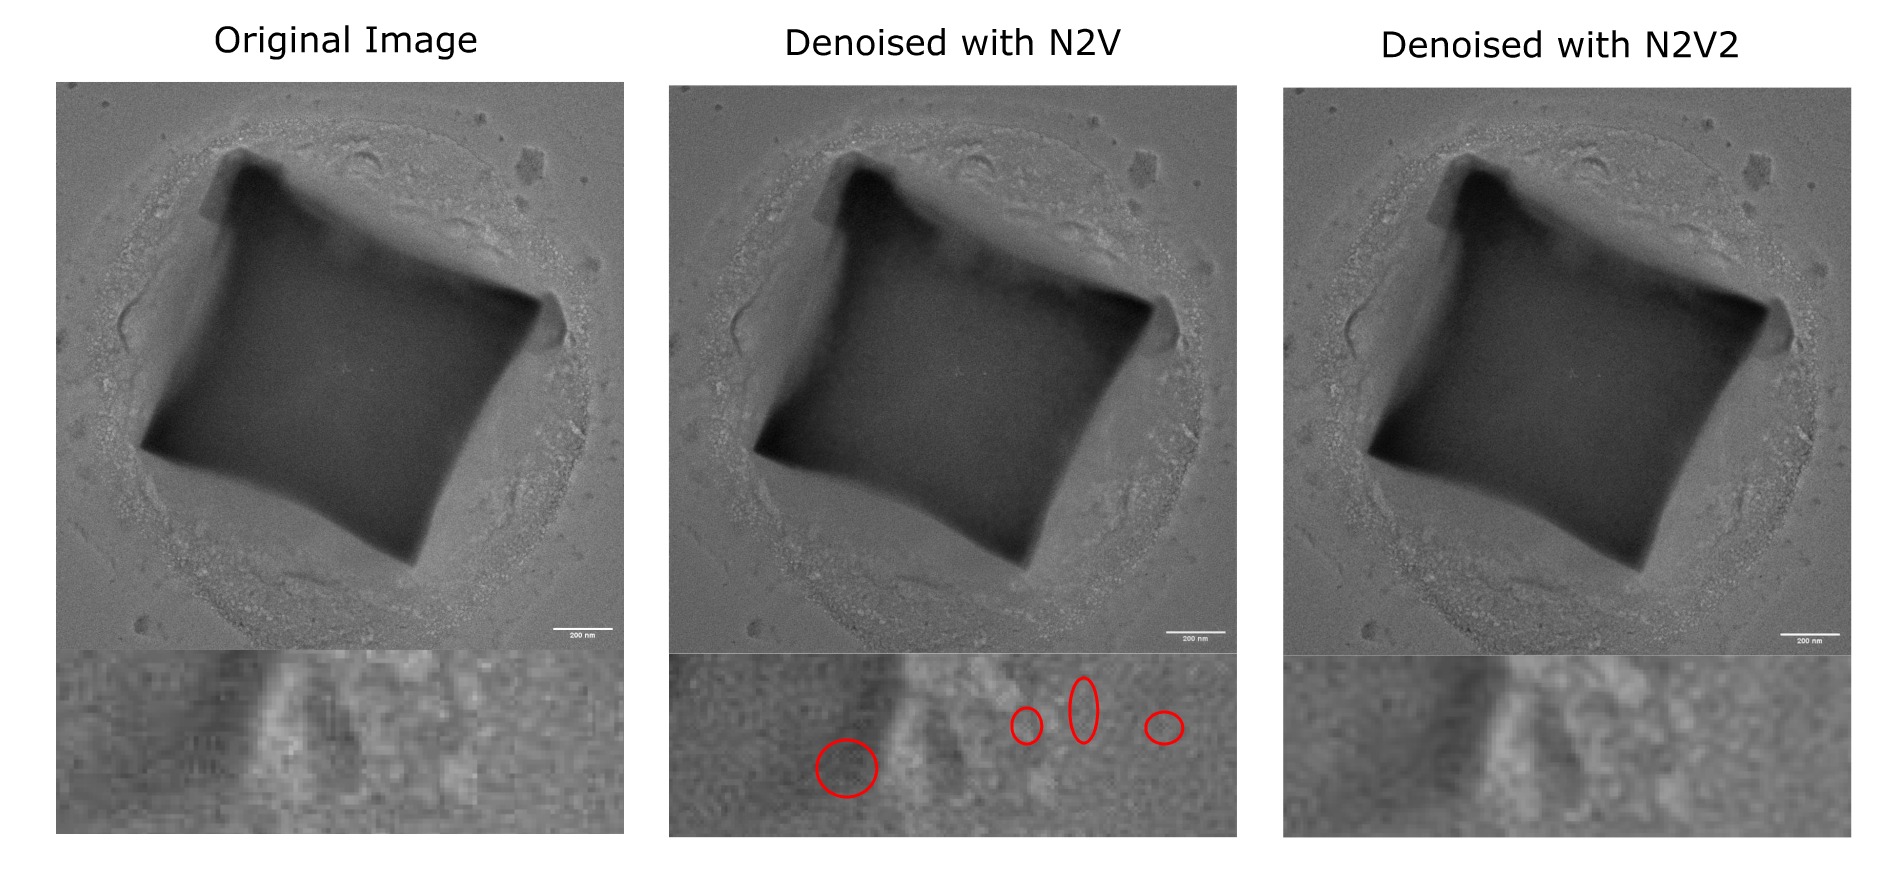

---

### **References:**

This notebook was heavily based on the Noise2Void (2D) notebook by the Zero-Cost Download for Microscopy Project, found here: [Noise2Void_2D_ZeroCostDL4Mic](https://colab.research.google.com/github/HenriquesLab/ZeroCostDL4Mic/blob/master/Colab_notebooks/Noise2Void_2D_ZeroCostDL4Mic.ipynb)

The paper about N2V by Krull et. al.: [Noise2Void - Learning Denoising from Single Noisy Images](https://arxiv.org/abs/1811.10980)

The paper for N2V2: [N2V2 -- Fixing Noise2Void Checkerboard Artifacts with Modified Sampling Strategies and a Tweaked Network Architecture](https://arxiv.org/abs/2211.08512)

Source code for Noise2Void was found here: https://github.com/juglab/n2v

# **Before Starting:**

This notebook can be used to train and evaluate models as well as denoise and display a random output.
> There are preloaded models you can access through section 4. If you only want to denoise images using one of these models or your own, then please run sections 1, 2 and 4.

For a photo tutorial on how to use this notebook, plus some potentially pertinent data, see [this powerpoint.](https://drive.google.com/file/d/1jaluUGUYpuHHOW_w7GgH9lleAdG9Fa1R/view?usp=drive_link)

**Please make sure you do the following before you begin:**

*   The notebook is designed only to take 2D (i.e. greyscale) .tiff files. Make sure your files are in the right format.
*   Sign into your Google account and upload all of your data to Google Drive. A sample basic data structure is as follows:
  * Training data
  * Data to be predicted
  * Results (containing your trained model and predicted images)
*   Make sure you are connected to a hosted runtime. You can verify this in cell 1.3.



# **1. Set Up Noise2Void:**

In [ ]:
#@title 1.1 Install N2V and dependencies:
!pip install n2v | grep -v 'Requirement already satisfied'
!pip install wget | grep -v 'Requirement already satisfied'

In [ ]:
#@title 1.2 Import key dependencies:
## N2V:
from n2v.models import N2VConfig, N2V
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from csbdeep.utils import plot_history

## Others:
import tifffile as tif
import numpy as np
from random import choice
import sys
import os
import shutil
import wget
import matplotlib.pyplot as plt
import time
import zipfile

!git clone https://github.com/gracefacetseng/n2v2-in-google-colab

In [ ]:
#@title 1.3 Check for GPU access
#@markdown To connect to a GPU, open "Notebook Settings" in the Edit tab and make sure the following settings are selected:

#@markdown **Runtime type:** Python 3

#@markdown **Hardware accelerator:** GPU

#@markdown Run this cell to make sure you have access to a GPU. If you are not, then please connect to a GPU runtime by following the instructions above and rerun this section.
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

if tf.test.gpu_device_name() == '':
  print('No GPU access detected. Please connect to a GPU runtime.')
else:
  print('GPU access detected')

# **2. Import Data**
Friendly reminder that you need a Google account and access to Google Drive to run this notebook!

In [ ]:
#@title Mount Google Drive to the notebook:

#@markdown To access your data, you have to first connect your Google Drive to this notebook.

#@markdown Run this cell and follow the instructions. Your files will appear in the "Files" tab on the left shortly under the folder called "mydrive", if not, then please reload the page. To copy a file path, open Files and find your folder/file, then right-click and select "Copy Path".

from google.colab import drive
drive.mount('/content/mydrive')

# **3. Loading/Training the Model**

In [ ]:
#@title 3.1 Load a pretrained model as initial values, if desired:
#@markdown **Note:** even if you are not loading a pretrained model, run this cell anyway.

use_pretrained_model = False #@param {type:'boolean'}
#@markdown Please copy and paste the file path to your pretrained model:
pretrained_model_path = '' #@param {type:'string'}

# obtain location of the pretrained model:
if use_pretrained_model:
  model_file_path = pretrained_model_path

# check if the model exists:
  if not os.path.exists(model_file_path):
    print('Model does not exist.')
    use_pretrained_model = False
  else:
    pass

if use_pretrained_model:
  print('Model', os.path.basename(pretrained_model_path),'was successfully loaded')
else:
  print('A pretrained model will not be used.')

In [ ]:
#@title 3.2 Import data and create output folders:
##obtain user inputs:
#@markdown Copy and paste the file path of the folder containing the noisy images you want to use as training data:
training_data = '' #@param {type:'string'}
#@markdown Copy and paste the file path of the folder where you want to save your model:
model_results = '' #@param {type:'string'}
#@markdown Give a unique name to your new model:
model_name = '' #@param {type:'string'}
#@markdown **Note:** if you use the same results folder for multiple models, giving the same name to two models may result in one being overwritten. PLEASE make sure you are giving a unique name to your new model.

# call random image:
testdir = training_data
random_img = choice(os.listdir(testdir))

# check file type
filename, filetype = os.path.splitext(random_img)
if filetype == '.tiff':
  filext = '*.tiff'
elif filetype == '.tif':
  filext = '*.tif'
else:
  print('The images you are trying to use are the wrong file type. File type of your images:', filetype)
  sys.exit()

#if pass, extract data
datagen = N2V_DataGenerator()
imgs = datagen.load_imgs_from_directory(directory=training_data, filter=filext)

# check dimensions; n2v2 only supports 2d images
random_img = tif.imread(training_data + '/' +random_img)
if not len(random_img.shape) == 2:
  print('Your images have the wrong number of dimensions. Number of dimensions:', len(random_img.shape))
  sys.exit()

print('Data successfully imported')

In [ ]:
#@title 3.3 Specify training parameters:
#@markdown ###**Basic Parameters:**
#@markdown Input the number of epochs that your model will be trained for:
number_of_epochs = 50 #@param {type:'integer'}
#@markdown Input the side length (in pixels) of the patches used for training. Must be between 64 and the side length of your images and be divisible by 8.
patch_size = 64 #@param {type:'integer'}

# check patch size:
img_x = random_img.shape[1]
img_y = random_img.shape[0]

if patch_size > min(img_y, img_x):
  patch_size = min(img_y, img_x)
  print('Patch size was larger than the dimensions of the training images; patch size modified.')

if not patch_size % 8 == 0:
  patch_size = int(patch_size/8)*8
  print('Patch size not divisible by 8; patch size modified.')

if not patch_size >= 64:
  patch_size = 64
  print('Patch size was smaller than 64; patch size modified.')

print('Patch size is set to '+str(patch_size)+'. Please confirm that this is the patch size you want to use.')

#@markdown ###**Advanced Parameters:**
batch_size = 128 #@param {type:'integer'}
#@markdown Batch size is the number of patches seen in each training step. A high batch size is required for stable training. Reduce this value if your GPU is overloaded.
number_of_steps = 0 #@param {type:'integer'}
#@markdown This is the number of training steps in each epoch. By default, this value is the number of patches divided by the batch size.
initial_learning_rate = 0.0004 #@param {type:'number'}
#@markdown An arbitrary initial learning rate. The model will occasionally adjust the learning rate during training.
percent_validation = 10 #@param {type:'number'}
#@markdown The portion of patches generated to be used as validation data, as a percentage.
data_augmentation = True #@param {type:'boolean'}
#@markdown Data augmentation generates additional patches that are rotated and mirrored. This can be useful for small datasets, but is not required for training and should be disabled if you are using a large dataset.

print('Parameters set.')

In [ ]:
#@title 3.4 Prepare your data and model for training:
patch_dims = (patch_size, patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_dims, augment=data_augmentation)
patch_shape = patches.shape
threshold = int(patches.shape[0]*(percent_validation/100))
X = patches[threshold:]
X_Val = patches[:threshold]

if number_of_steps == 0:
  number_of_steps = int(patch_shape[0]/batch_size)+1

config = N2VConfig(X, unet_kern_size=3,
                   train_steps_per_epoch=number_of_steps, train_epochs=number_of_epochs, train_loss='mse', batch_norm=True,
                   train_batch_size=batch_size, n2v_perc_pix=0.198, n2v_neighborhood_radius=5,
                   single_net_per_channel=False, train_learning_rate=initial_learning_rate, blurpool=True, skip_skipone=True,
                   n2V_manipulator='median', unet_residual=False)

model = N2V(config=config, name=model_name, basedir=model_results)

if use_pretrained_model:
  model.load_weights(model_file_path)
  print('Pretrained model loaded.')


print('Configuration complete. Ready to train.')

In [ ]:
#@title 3.5 Train your model:
if not sys.warnoptions:
  import warnings
  warnings.filterwarnings('ignore')

start = time.time()
history = model.train(X, X_Val)

model.export_TF(name='N2V2',
                description='Noise2Void2 on Google Colab, by Grace Tseng',
                authors=['User'],
                test_img=X_Val[0,...,0], axes='YX',
                patch_shape=patch_dims)

print('Training Complete')
print('Time Elapsed:', time.strftime("%H:%M:%S", time.gmtime(time.time()-start)))



print('Model was successfully exported in folder:', model_results)

In [ ]:
#@title 3.6 Quality Control:
#@markdown Run this cell to plot your training and validation loss for your model.

#@markdown Loss functions in machine learning are used to evaluate the training progress of a model. When both training loss and validation loss stop increasing, a model is effectively finished training. In a nutshell:

#@markdown **Training loss:** How well your model can predict an image from a sample in your training data compared to a ground-truth image.

#@markdown **Validation loss:** How well your model can predict an image from a sample in your validation data, i.e., how well your model can handle unfamiliar data.

#@markdown It is natural for your validation loss to be consistently higher than your training loss. However, if the validation loss suddenly increases while the training loss stays constant, your model is overfitting to your training data. In this case, you should increase the size of your training dataset.

#@markdown For more information, [see this lovely explanation by Google.](https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss)

plt.figure()
plot_history(history, ['loss', 'val_loss']);

# **4. Using the Model**

In [ ]:
#@title 4.1 Import your model and data to predict:
#@markdown Paste the file path of the folder containing the images you wish to denoise:
data_folder = '' #@param {type:'string'}
#@markdown Paste the file path of the folder you want to store your predicted data in:
results_folder = '' #@param {type:'string'}

print('Data successfully loaded.')

# load model
#@markdown Check this box if you want to use a pretrained model. Otherwise, If you had just trained a model from scratch, it will be used by default.
use_pretrained_model = False #@param {type:"boolean"}

# choose model version
#@markdown Pick the set of model parameters you want to use. The best weights give the lowest validation loss; the last weights are the latest computed weights.
weights_choice = 'best' #@param ['best','last']
if weights_choice == 'best':
  pretrained_model_file = 'weights_best.h5'
else:
  pretrained_model_file = 'weights_last.h5'

#@markdown Pretrained model folders can be found in the folder "pretrained_models" in the Github repository.
pretrained_model_selection = 'Model_from_folder' #@param ['Model_from_folder', 'alveolar_stem_cells_10533', 'C.reinhardtii_10870', 'mitochondria_11449', 'mitochondria_mitolab', 'mouse_brain_11415', 'mouse_optic_nerve_steyer-mobius', 't-cells_10329', 'villi_10967']
if use_pretrained_model:
  if pretrained_model_selection == 'Model_from_folder':
    #@markdown If you wish to use a model you trained yourself, please select "Model_from_folder" above and paste the file path here:
    pretrained_model_path = "" #@param {type:"string"}
    pretrained_model_name = os.path.basename(pretrained_model_path)
  else:
    pretrained_model_path = '/content/n2v2-in-google-colab/pretrained_models/'+pretrained_model_selection
    pretrained_model_name = pretrained_model_selection

  pretrained_model_folder = os.path.dirname(pretrained_model_path)

else:
    pretrained_model_folder = model_results
    pretrained_model_path = model_results+'/'+model_name
    pretrained_model_name = model_name

#check if model exists:
full_model_path = pretrained_model_path+'/'+pretrained_model_file
if os.path.exists(full_model_path):
  print('Model',pretrained_model_name,'will be used.')
else:
  print('Model does not exist.')



In [ ]:
#@title 4.2 Generate predictions:
#@markdown Don't forget to download your data! Your predictions should be visible with ImageJ or Napari.

# load model
model = N2V(config=None, name=pretrained_model_path, basedir=pretrained_model_folder)
model.load_weights(pretrained_model_file)

# predict and print denoised images:
for root, dirs, files in os.walk(data_folder):
 for name in files:
    filename = os.path.basename(name)
    inputs = tif.imread(os.path.join(root, name)).astype(np.float32)
    predictions = model.predict(inputs, axes='YX')
    tif.imwrite(os.path.join(results_folder, filename), predictions)

print('Predictions complete. Find your predicted data in folder', os.path.basename(results_folder))

In [ ]:
#@title 4.3 Return a random input image and its denoised output:
random_choice = choice(os.listdir(data_folder))
input = tif.imread(data_folder+"/"+random_choice)

os.chdir(results_folder)
output = tif.imread(results_folder+"/"+random_choice)

plt.figure(figsize=(14,20))
plt.set_cmap('gray')
plt.subplot(1,2,1)
plt.imshow(input)
plt.title('Input Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(output)
plt.title('Predicted Image')
plt.axis('off')